### Facial keypoints detection

#### Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, BatchNormalization, MaxPool2D, Flatten, Dropout
from keras.metrics import RootMeanSquaredError
from keras.utils import plot_model

from sklearn.model_selection import train_test_split

#### Constants

In [2]:
img_height, img_width = 96, 96

#### Dataset loading

The given dataset has already been separated to the train and the test part (2 .csv files zipped for the sake of good memory utilization). 
`train` and `test` archives contains .csv file with coordinates of each keypoint as well as the image.

In [3]:
train = pd.read_csv('./dataset/training.zip', compression='zip')
test = pd.read_csv('./dataset/test.zip', compression='zip')
IdLookupTable = pd.read_csv('./dataset/IdLookupTable.csv',header=0, sep=',', quotechar='"')

Each keypoint is specified by an (x, y) real-valued pair in the space of pixel indices. There are 15 keypoints, which represent the following elements of the face:

*left_eye_center*, *right_eye_center*, *left_eye_inner_corner*, *left_eye_outer_corner*, *right_eye_inner_corner*, *right_eye_outer_corner*, *left_eyebrow_inner_end*, *left_eyebrow_outer_end*, *right_eyebrow_inner_end*, *right_eyebrow_outer_end*, *nose_tip*, *mouth_left_corner*, *mouth_right_corner*, *mouth_center_top_lip*, *mouth_center_bottom_lip*

Left and right here refers to the point of view of the subject.

The input image is given in the last field of the data files, and consists of a list of pixels (ordered by row), as integers in (0,255). The images are 96x96 pixels.

##### Train dataset preview
Each row contains the (x,y) coordinates for 15 keypoints, and image data as row-ordered list of pixels.

In [4]:
print('The number of samples into the train data is {}.'.format(train.shape[0]))

train.head().T

The number of samples into the train data is 7049.


,0,1,2,3,4
left_eye_center_x,66.033564,64.332936,65.057053,65.225739,66.725301
left_eye_center_y,39.002274,34.970077,34.909642,37.261774,39.621261
right_eye_center_x,30.227008,29.949277,30.903789,32.023096,32.24481
right_eye_center_y,36.421678,33.448715,34.909642,37.261774,38.042032
left_eye_inner_corner_x,59.582075,58.85617,59.412,60.003339,58.56589
left_eye_inner_corner_y,39.647423,35.274349,36.320968,39.127179,39.621261
left_eye_outer_corner_x,73.130346,70.722723,70.984421,72.314713,72.515926
left_eye_outer_corner_y,39.969997,36.187166,36.320968,38.380967,39.884466
right_eye_inner_corner_x,36.356571,36.034723,37.678105,37.618643,36.98238
right_eye_inner_corner_y,37.389402,34.361532,36.320968,38.754115,39.094852


##### Test dataset preview
Each row contains ImageId and image data as row-ordered list of pixels

In [5]:
print('The number of samples into the test data is {}.'.format(test.shape[0]))

test.head()

The number of samples into the test data is 1783.


,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


#### Data preprocessing - missing values

In [6]:
train.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

In [7]:
print('Maximal number of missing columns is %d, which is %.2f%%' %(max(train.isnull().sum()), 100. * max(train.isnull().sum()) / train.shape[0]))

Maximal number of missing columns is 4824, which is 68.44%


##### Dropping missing values
First technique can be to drop all missing values. This will drop almost ~70% of the training dataset.

In [8]:
def drop_missing_values():  
    train_dropped_missing_values = train.dropna()
    return train_dropped_missing_values

##### Fill missing values
Another technique can be to fill all the missing values with something. Common coices can be to use average od median as a missing values.

In [9]:
def fill_missing_values():  
    train_filled_values = train.fillna(method = 'ffill', inplace=False)
    return train_filled_values

In [10]:
def solve_missing_values(method: str):
    if method == 'drop':
        return drop_missing_values()
    elif method == 'ffill':
        return fill_missing_values()

##### Solve missing values

In [11]:
train_no_missing_values = solve_missing_values('ffill')

In [12]:
number_of_rows_train, number_of_columns_train = train_no_missing_values.shape
print('Shape of train data without any missing values are ({}, {}).'.format(number_of_rows_train , number_of_columns_train))
train_no_missing_values.isnull().sum().any()

Shape of train data without any missing values are (7049, 31).


False

There is no missing values any more!

#### Images and keypoints preview

The last column (accessed using the name `Image`) of the train dataset represents an image. If there are any blank spaces, represents by null values, in the pixels they will be replaced with 0. The pixel values will be normalized in the range [0, 1].

In [13]:
images = []
labels = []

for index, sample in train_no_missing_values.iterrows():

    face_pixel = np.array(sample['Image'].split(' '), dtype='float')
    face_pixel = np.reshape(face_pixel, (img_height, img_width, 1))
    images.append(face_pixel)

    labels.append(sample[0:30])

images = np.array(images)
labels = np.array(labels, dtype = 'float')

images.shape, labels.shape

((7049, 96, 96, 1), (7049, 30))

Preview random image

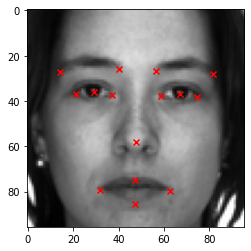

In [14]:
sample_image_number = 1235
plt.imshow(images[sample_image_number], cmap='gray')
plt.scatter(labels[sample_image_number][0:30:2], labels[sample_image_number][1:30:2], marker='x', c = 'red')
plt.show()

#### Model

Testset will be splitted into 3 groups: train, validate, test. The relative size of each group will be the following (train, validate, test) = (80%, 10%, 10%)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

print('Shape of train dataset is ({}, {}).'.format(X_train.shape, y_train.shape))
print('Shape of validation dataset is ({}, {}).'.format(X_val.shape, y_val.shape))
print('Shape of test dataset is ({}, {}).'.format(X_test.shape, y_test.shape))


Shape of train dataset is ((5639, 96, 96, 1), (5639, 30)).
Shape of validation dataset is ((705, 96, 96, 1), (705, 30)).
Shape of test dataset is ((705, 96, 96, 1), (705, 30)).


Hence this dataset is small (~10<sup>4</sup> inputs) this division will work fine.

##### Neural Netowrk

Simple neural network model

In [16]:
model_nn = Sequential(name="Deep Neural Network")
model_nn.add(Flatten(input_shape=(96, 96, 1)))
model_nn.add(Dense(128, activation='relu'))
Dropout(0.5)
model_nn.add(Dense(128, activation='relu'))
Dropout(0.5)
model_nn.add(Dense(64, activation='relu'))
model_nn.add(Dense(30))

model_nn.summary()

Model: "Deep Neural Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 30)                1950      
                                                                 
Total params: 1,206,494
Trainable params: 1,206,494
Non-trainable params: 0
_________________________________________________________________


In [17]:
plot_model(model_nn, to_file='Deep Neural Network.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
model.compile(optimizer='Adam',  metrics=[RootMeanSquaredError(), 'accuracy'], loss='mae')

In [ ]:
%%time
history_nn = model.fit(images, labels, epochs=200, batch_size=32, shuffle=True, validation_split=0.2)

In [ ]:
print(history_nn.history.keys())

In [ ]:

plot_loss(history_nn.history,"NN",plt)


#### Convolution Neural Network

In [ ]:
model = Sequential()

model.add(Conv2D(128, kernel_size=(3, 3), input_shape=(img_height, img_width, 1),
                activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3),activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3),activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(30))
model.summary()

SOLUTION


In [ ]:
train.fillna(method = 'ffill', inplace=True) # forward fill

In [ ]:
m, n = train.shape
m1, n1 = test.shape

In [ ]:
train.isnull().sum().any()

In [ ]:
img = []
# Iterate over all the rows and split the individual entries of Image column
# if there are any blank spaces i.e. null values in the pixels then simply replace it with 0
for i in range(m):
    face_pixel = np.array(train['Image'][i].split(' '), dtype='float')
    face_pixel = np.reshape(face_pixel, (img_height,img_width,1))
    face_pixel /=255
    img.append(face_pixel)
img = np.array(img)

In [ ]:
X_train = img
train.drop('Image', axis = 1, inplace=True)
y_train = []

for i in range(len(train)):
    y = train.iloc[i,:].values
    y_train.append(y)

In [ ]:
y_train = np.array(y_train,dtype = 'float')

In [ ]:
X_train.shape, y_train.shape

In [ ]:
plt.imshow(X_train[1550])
plt.show()

In [ ]:
def image_with_keypoints(df, index):
    image = plt.imshow(X_train[index],cmap='gray')
    l = []
    for i in range(1,31,2):
        l.append(plt.plot(y_train[index][i-1], y_train[index][i], 'r*'))
        
    return image, l

In [ ]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    image_with_keypoints(X_train, i)

plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import RootMeanSquaredError
print("Successfully Imported")

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(96, 96, 1)))
model.add(Dense(128, activation='relu'))
Dropout(0.5)
model.add(Dense(128, activation='relu'))
Dropout(0.5)
model.add(Dense(64, activation='relu'))
model.add(Dense(30))

model.summary()

In [ ]:
model.compile(optimizer='Adam',  metrics=[RootMeanSquaredError(), 'accuracy'], loss='mae')

In [ ]:
%%time
history = model.fit(X_train,y_train,epochs = 2,validation_split = 0.2)

In [ ]:
print(history.history.keys())

In [ ]:
model = Sequential()

model.add(Conv2D(128, kernel_size=(3, 3), input_shape=(img_height, img_width, 1),
                activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3),activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3),activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(30))
model.summary()

In [ ]:
model.compile(optimizer='Adam',  metrics=[RootMeanSquaredError(), 'accuracy'], loss='mae')

In [ ]:
%%time
history = model.fit(X_train,y_train,epochs = 2, batch_size = 32,validation_split = 0.2)

In [ ]:
print(history.history.keys())

In [ ]:
def plot_loss(hist,name,plt):
    '''
    RMSE_TF: if True, then RMSE is plotted with original scale 
    '''
    loss = hist['loss']
    val_loss = hist['val_loss']
    plt.plot(loss,"--",linewidth=3,label="train:"+name)
    plt.plot(val_loss,linewidth=3,label="val:"+name)

plot_loss(history.history,"CNN",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")
plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(acc,"--",linewidth=3,label="train : CNN")
plt.plot(val_acc,linewidth=3,label="val : CNN")
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

In [ ]:
test_images = []
for i in range(len(test)):
    item = np.array(test['Image'][i].split(' '), dtype='float')
    item = np.reshape(item, (img_height, img_width, 1))
    item /= 255
    test_images.append(item)
    
test_images = np.array(test_images, dtype='float')

In [ ]:
plt.imshow(test_images[0].reshape(96, 96))
plt.show()

In [ ]:
predict = model.predict(test_images)

In [ ]:
feature_names = list(IdLookupTable['FeatureName'])
image_ids = list(IdLookupTable['ImageId']-1)
row_ids = list(IdLookupTable['RowId'])

feature_list = []
for feature in feature_names:
    feature_list.append(feature_names.index(feature))

In [ ]:
predictions = []
for x,y in zip(image_ids, feature_list):
    predictions.append(predict[x][y])

In [ ]:
row_ids = pd.Series(row_ids, name = 'RowId')
locations = pd.Series(predictions, name = 'Location')
locations = locations.clip(0.0,96.0)
submission_result = pd.concat([row_ids,locations],axis = 1)
submission_result.to_csv('submission.csv',index = False)

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')